# Process Effectiveness Data

Data from [GitHub](https://github.com/gtvalab/ChartsEffectiveness/tree/master/Raw-Data).

In [1]:
import pandas as pd
import itertools
import scipy.stats as stats
import json
import numpy as np

In [2]:
df_orig = pd.read_csv('../bahador/OverallData.csv')

# fix typo
df_orig.visualization.replace({'Scatterplot': 'ScatterPlot'}, inplace=True)

In [3]:
# Remove pie charts and tables
df = df_orig
df = df[df.visualization != 'PieChart']
df = df[df.visualization != 'Table']

In [4]:
np.unique(df.task)

array(['Anomalies', 'Cluster', 'Correlation', 'Derived', 'Distribution',
       'Extremum', 'Filter', 'Order', 'Range', 'Retrieve'], dtype=object)

In [5]:
# rename tasks into our taxonomy
df.task.replace({
    'Extremum': 'extremum',
    'Range': 'extremum',
    
    'Retrieve': 'value',
    
    'Filter': 'compare',
    'Order': 'compare',
    
    'Derived': 'derived'
}, inplace=True)

# drop other tasks

df = df[df.task != 'Anomalies']
df = df[df.task != 'Cluster']
df = df[df.task != 'Correlation']
df = df[df.task != 'Distribution']

In [6]:
np.unique(df.task)

array(['compare', 'derived', 'extremum', 'value'], dtype=object)

In [7]:
df

,task,x,y,dataset,visualization,accuracy,rank,time
1440,derived,Nominal,Numerical,CarData,BarChart,100,2,14
1441,derived,Nominal,Numerical,CarData,BarChart,100,1,11
1442,derived,Nominal,Numerical,CarData,BarChart,0,3,26
1443,derived,Nominal,Numerical,CarData,BarChart,100,1,11
1444,derived,Nominal,Numerical,CarData,BarChart,100,3,36
1445,derived,Nominal,Numerical,CarData,BarChart,100,3,41
1446,derived,Nominal,Numerical,CarData,BarChart,0,1,28
1447,derived,Nominal,Numerical,CarData,BarChart,100,4,10
1448,derived,Nominal,Numerical,CarData,BarChart,100,2,90
1449,derived,Nominal,Numerical,CarData,BarChart,0,3,22


In [8]:
gb = df.groupby(['visualization'])
gb.describe()

accuracy                                                         \
                 count       mean        std  min    25%    50%    75%    max   
visualization                                                                   
BarChart         648.0  91.975309  27.188494  0.0  100.0  100.0  100.0  100.0   
LineChart        648.0  81.172840  39.123090  0.0  100.0  100.0  100.0  100.0   
ScatterPlot      648.0  87.037037  33.615498  0.0  100.0  100.0  100.0  100.0   

                rank            ...               time                        \
               count      mean  ...    75%  max  count       mean        std   
visualization                   ...                                            
BarChart       648.0  2.209877  ...    3.0  5.0  648.0  18.347222  13.351095   
LineChart      648.0  3.759259  ...    5.0  5.0  648.0  21.740741  18.187519   
ScatterPlot    648.0  3.700617  ...    5.0  5.0  648.0  21.094136  17.528306   

                                             
               min   25%   50%   75%    max  
visualization                                
BarChart       2.0  10.0  15.0  23.0  151.0  
LineChart      1.0  11.0  16.0  25.0  203.0  
ScatterPlot    2.0  11.0  17.0  25.0  170.0  

[3 rows x 24 columns]

In [9]:
gb = df.groupby(['visualization', 'task', 'x', 'y'])  # , 'dataset'

In [10]:
gb.describe()

accuracy                         \
                                              count        mean        std   
visualization task     x         y                                           
BarChart      compare  Nominal   Numerical     72.0   90.277778  29.833917   
                       Numerical Numerical     72.0   87.500000  33.303978   
                       Ordinal   Numerical     72.0   94.444444  23.066889   
              derived  Nominal   Numerical     36.0   86.111111  35.073619   
                       Numerical Numerical     36.0   94.444444  23.231068   
                       Ordinal   Numerical     36.0   91.666667  28.030596   
              extremum Nominal   Numerical     72.0   91.666667  27.832497   
                       Numerical Numerical     72.0   97.222222  16.548880   
                       Ordinal   Numerical     72.0   86.111111  34.825746   
              value    Nominal   Numerical     36.0   97.222222  16.666667   
                       Numerical Numerical     36.0  100.000000   0.000000   
                       Ordinal   Numerical     36.0   91.666667  28.030596   
LineChart     compare  Nominal   Numerical     72.0   93.055556  25.599235   
                       Numerical Numerical     72.0   61.111111  49.091910   
                       Ordinal   Numerical     72.0   93.055556  25.599235   
              derived  Nominal   Numerical     36.0   72.222222  45.425676   
                       Numerical Numerical     36.0   61.111111  49.441323   
                       Ordinal   Numerical     36.0   66.666667  47.809144   
              extremum Nominal   Numerical     72.0   98.611111  11.785113   
                       Numerical Numerical     72.0   70.833333  45.771939   
                       Ordinal   Numerical     72.0   94.444444  23.066889   
              value    Nominal   Numerical     36.0   80.555556  40.138649   
                       Numerical Numerical     36.0   69.444444  46.717659   
                       Ordinal   Numerical     36.0   88.888889  31.872763   
ScatterPlot   compare  Nominal   Numerical     72.0   97.222222  16.548880   
                       Numerical Numerical     72.0   76.388889  42.767157   
                       Ordinal   Numerical     72.0   81.944444  38.734884   
              derived  Nominal   Numerical     36.0   91.666667  28.030596   
                       Numerical Numerical     36.0   69.444444  46.717659   
                       Ordinal   Numerical     36.0   86.111111  35.073619   
              extremum Nominal   Numerical     72.0   91.666667  27.832497   
                       Numerical Numerical     72.0   87.500000  33.303978   
                       Ordinal   Numerical     72.0   91.666667  27.832497   
              value    Nominal   Numerical     36.0   97.222222  16.666667   
                       Numerical Numerical     36.0   77.777778  42.163702   
                       Ordinal   Numerical     36.0   91.666667  28.030596   

                                                                               \
                                              min    25%    50%    75%    max   
visualization task     x         y                                              
BarChart      compare  Nominal   Numerical    0.0  100.0  100.0  100.0  100.0   
                       Numerical Numerical    0.0  100.0  100.0  100.0  100.0   
                       Ordinal   Numerical    0.0  100.0  100.0  100.0  100.0   
              derived  Nominal   Numerical    0.0  100.0  100.0  100.0  100.0   
                       Numerical Numerical    0.0  100.0  100.0  100.0  100.0   
                       Ordinal   Numerical    0.0  100.0  100.0  100.0  100.0   
              extremum Nominal   Numerical    0.0  100.0  100.0  100.0  100.0   
                       Numerical Numerical    0.0  100.0  100.0  100.0  100.0   
                       Ordinal   Numerical    0.0  100.0  100.0  100.0  100.0   
              value    Nomin

In [11]:
# trying to make sense of x and y
df.groupby(['x', 'y']).describe()

accuracy                                                  \
                       count       mean        std  min    25%    50%    75%   
x         y                                                                    
Nominal   Numerical    648.0  91.666667  27.659891  0.0  100.0  100.0  100.0   
Numerical Numerical    648.0  79.629630  40.306229  0.0  100.0  100.0  100.0   
Ordinal   Numerical    648.0  88.888889  31.451245  0.0  100.0  100.0  100.0   

                             rank            ...               time  \
                       max  count      mean  ...    75%  max  count   
x         y                                  ...                      
Nominal   Numerical  100.0  648.0  3.263889  ...    4.0  5.0  648.0   
Numerical Numerical  100.0  648.0  3.219136  ...    4.0  5.0  648.0   
Ordinal   Numerical  100.0  648.0  3.186728  ...    4.0  5.0  648.0   

                                                                         
                          mean        std  min   25%   50%   75%    max  
x         y                                                              
Nominal   Numerical  19.753086  16.124635  2.0  11.0  16.0  24.0  203.0  
Numerical Numerical  22.652778  18.244132  2.0  12.0  18.0  27.0  153.0  
Ordinal   Numerical  18.776235  14.892534  1.0   9.0  14.0  23.0  151.0  

[3 rows x 24 columns]

In [12]:
def parse(group):
    task = group['task'].iloc[0]
    x = group['x'].iloc[0]
    
    fields = [
        {'name': 'n', 'type': 'string', 'cardinality': 9},  # 6 or 12
        {'name': 'q1', 'type': 'number', 'cardinality': 25},  # between 5 and 50, depending on attribute
        {'name': 'q2', 'type': 'number'},
    ]
    
    # we only specify interestingness if not both x and y are interesting
    
    # tasks: 'compare', 'derived', 'extremum', 'value'
    
    x_tasks = []  # ['Distribution', 'Cluster']
    y_tasks = ['extremum', 'value']  # ['Extremum', 'Retrieve']
    
    if task in x_tasks:
        # mostly x is interesting
        if x == 'Numerical':
            fields[1]['interesting'] = True
        else:  # Ordinal or Nominal
            fields[0]['interesting'] = True
    elif task in y_tasks:
        # mostly y is interesting
        fields[2]['interesting'] = True

    enc = {}
    
    if x == 'Numerical':
        enc['x'] = {'field': 'q1', 'type': 'quantitative'}
    elif x == 'Nominal':
        enc['x'] = {'field': 'n', 'type': 'nominal'}
    else:  # x is Ordinal
        enc['x'] = {'field': 'n', 'type': 'ordinal'}

    # y is always numerical and always aggregated
    enc['y'] = {'field': 'q2', 'type': 'quantitative', 'aggregate': 'mean'}
    
    t = group['visualization'].iloc[0]
    if t == 'BarChart':
        mark = 'bar'
    elif t == 'LineChart':
        mark = 'line'
    elif t == 'ScatterPlot':
        mark = 'point'
        
    spec = {
        'mark': mark,
        'encoding': enc
    }

    return {
        'fields': fields,
        'task': task,
        'spec': spec,
        'visualization': group['visualization'].iloc[0],
        'isCorrect': list(map(lambda x: True if x == 100 else False, group['accuracy'])),
        'completionTime': group['time']
    }

In [13]:
specs = pd.DataFrame(columns=['fields', 'task', 'spec', 'visualization',
                              'isCorrect'])
for name, group in gb:
    parsed = parse(group)
    specs = specs.append(parsed, ignore_index=True)
    
print('Number of groups', len(specs))

Number of groups 36


In [14]:
grouped_specs = specs.groupby(['task'])

print(len(grouped_specs))

4


In [15]:
grouped_specs.visualization.describe()

,count,unique,top,freq
task,,,,
compare,9,3,LineChart,3
derived,9,3,LineChart,3
extremum,9,3,LineChart,3
value,9,3,LineChart,3


In [16]:
training = []

for name, group in grouped_specs:
    for neg, pos in itertools.combinations(range(len(group)), 2):
        negative = group.iloc[neg]
        positive = group.iloc[pos]
        
        # Run Fisher's test with unpaired data
        # https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.fisher_exact.html
        contingency_table = [[np.sum(negative.isCorrect), len(negative.isCorrect) - np.sum(negative.isCorrect)],
                             [np.sum(positive.isCorrect), len(positive.isCorrect) - np.sum(positive.isCorrect)]]
        oddsratio, p = stats.fisher_exact(contingency_table)
#         if p > .01:
#            # run Welch's t-test: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_ind.html
#            t, p = stats.ttest_ind(negative.completionTime, positive.completionTime, equal_var=False)
        if p <= .01:
            training.append({
                'fields': group.iloc[0]['fields'],
                'task': group.iloc[0]['task'],
                'negative': negative.spec,
                'positive': positive.spec,
                'pvalue': round(p, 6)
            })

In [17]:
len(training)

27

In [18]:
with open('../data/training/bahador.json', 'w') as f:
    json.dump({'$schema': './schema.json', 'source': 'bahador', 'data': training}, f, indent=2)

## Experiment with tasks to figure out what tasks are actually different

In [19]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [20]:
tasks = df_orig.drop(['rank'], axis=1).groupby(['task', 'visualization']).agg(['mean'])  # ,'std'
X = tasks.unstack()
X

accuracy                                               \
                    mean                                                
visualization   BarChart  LineChart   PieChart ScatterPlot      Table   
task                                                                    
Anomalies      75.000000  69.444444  69.444444   83.333333  68.518519   
Cluster        96.296296  58.333333  97.222222   75.925926  85.185185   
Correlation    80.555556  88.888889  66.666667   86.111111  52.777778   
Derived        90.740741  66.666667  89.814815   82.407407  93.518519   
Distribution   77.777778  70.370370  66.666667   75.000000  66.666667   
Extremum       94.444444  92.592593  93.611111   94.444444  93.518519   
Filter         91.666667  88.888889  92.592593   87.962963  93.518519   
Order          89.814815  75.925926  85.185185   82.407407  82.407407   
Range          88.888889  83.333333  87.962963   86.111111  83.333333   
Retrieve       96.296296  79.629630  92.592593   88.888889  96.296296   

                    time                                               
                    mean                                               
visualization   BarChart  LineChart   PieChart ScatterPlot      Table  
task                                                                   
Anomalies      10.351852  14.518519  19.398148   13.870370  17.129630  
Cluster        14.342593  20.000000  12.750000   16.907407  17.722222  
Correlation     9.805556   7.666667  20.416667    9.666667  18.569444  
Derived        20.833333  24.185185  18.462963   22.601852  16.129630  
Distribution   23.555556  26.759259  27.138889   21.425926  29.037037  
Extremum       12.138889  14.527778  17.712963   14.064815  17.537037  
Filter         18.787037  32.074074  30.203704   29.879630  20.231481  
Order          21.842593  26.037037  33.768519   28.611111  30.342593  
Range          24.435185  18.546296  19.601852   17.592593  22.314815  
Retrieve       12.046296  15.074074  10.722222   13.814815   9.425926

In [21]:
task_names = np.array(X.index)

In [22]:
model = KMeans(n_clusters=4)
# model = SpectralClustering(n_clusters=4)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
model.labels_

array([1, 2, 1, 2, 1, 0, 3, 3, 2, 0], dtype=int32)

In [24]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)
x0, x1 = reduced_data[:, 0], reduced_data[:, 1]

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/envs/asp/lib/python3.6/site-packages/matplotlib/pyplot.py'>

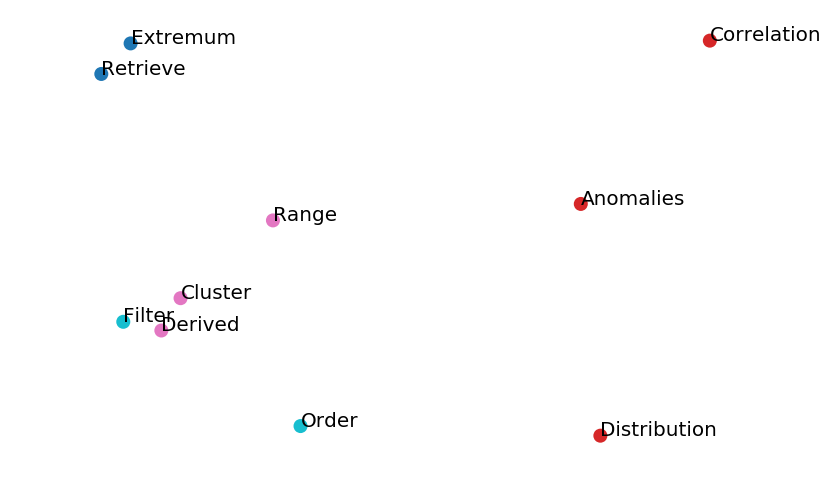

In [25]:
plt.scatter(x0, x1, c=model.labels_, cmap=plt.cm.tab10)
for i, txt in enumerate(task_names):
    plt.annotate(txt, (x0[i],x1[i]))
plt.axis('off')
plt